# Overview

In this program we will be taking a speech audio file, and classify sections as either speaking or a non speaking segment.

## Intensity based Approach
To begin, we will simple graph the audio intensity, choose a cutoff intensity, and graph verticle lines to seperate speaking sections from non-speaking (background noise)

### Let's begin by importing the libraries we'll use and by loading the necessary audio files  

In [138]:
import matplotlib.pyplot as plt   #used for displaying and graphing our audio files
import matplotlib.patches as mpatches
%matplotlib inline
from scipy.io import wavfile      #used to import our audio files
import IPython.display as ipd     #used to play audio in the notebook

In [35]:
#recording of a sentence 
freq, voice = wavfile.read("gabi_sample.wav")
length = voice.shape[0]/freq
print("Sampling Frequency (Hz): ", freq)
print("Shape of our audio file: ", voice.shape)
print("Length of our audio file:", voice.shape[0]/freq, 'seconds')

Sampling Frequency (Hz):  44100
Shape of our audio file:  (220500,)
Length of our audio file: 5.0 seconds


In [36]:
ipd.Audio(voice, rate=freq)

### Next we will visual the raw audio data
Note: We are looking at the sound intensity on the y-axis and samples on the x-axis

Text(0, 0.5, 'Volume')

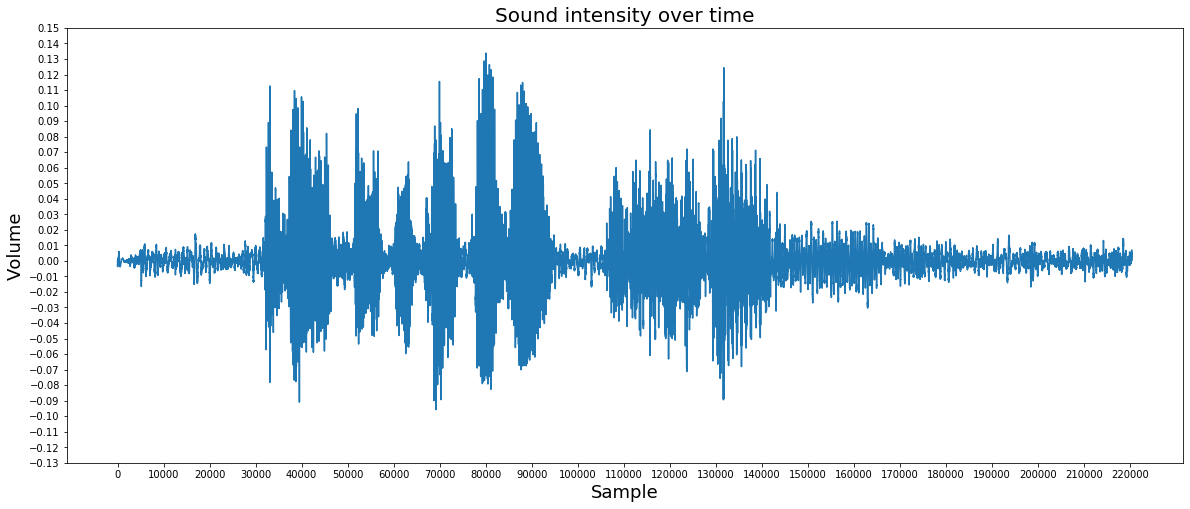

In [56]:
plt.figure(figsize=(20,8))
plt.plot(voice)
plt.xticks(np.arange(0, freq*length, step=10000))
plt.yticks(np.arange(-0.13, 0.15, step=0.01))
plt.title('Sound intensity over time', fontsize=20)
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Volume', fontsize=18)

Upon inspecting this graph, it would appear that the cutoff for speech is somewhere around the 0.03 intensity.
Let's create the same graph with horizontal lines for the cutoff frequencies.

Text(0, 0.5, 'Volume')

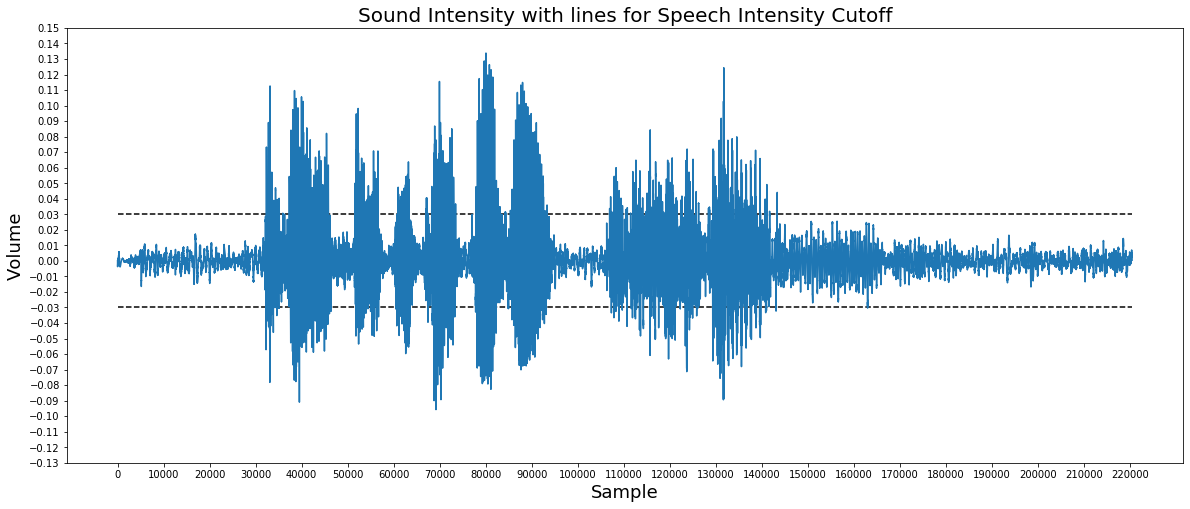

In [61]:
cutoff_for_speaking = 0.03   #we can adjust this later if we would like
plt.figure(figsize=(20,8))
plt.plot(voice)

#horizontal lines
plt.hlines(y=cutoff_for_speaking, xmin=0, xmax=len(voice), colors='k', linestyles='dashed')
plt.hlines(y=-cutoff_for_speaking, xmin=0, xmax=len(voice), colors='k', linestyles='dashed')

#our labels and ticks
plt.xticks(np.arange(0, freq*length, step=10000))
plt.yticks(np.arange(-0.13, 0.15, step=0.01))
plt.title('Sound Intensity with lines for Speech Intensity Cutoff', fontsize=20)
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Volume', fontsize=18)



### Separating speaking and non-speaking audio (using intensity)

This will be done by drawing verticle lines that seperate speaking from non-speaking portions

Since sound intensity will oscillate positive to negative, we are more concerned with whether the amplitude over a period is greater than our `cutoff_for_speech`.

To estimate the amplitude we will look at frames of 1000 data points(approximately 25ms windows) from our audio array. We will find the average of the top N values(`amps`) and if it greater that our `cutoff_for_speech` we classify that postion as speaking.

In [215]:
frame = 1000            #amount of points we look at when determining max amplitude 
amps= 20                #how many of the top values to average 
speaking_time = []      #list of dict that will store classification{start:int, stop:int,type:speech/silence}
current_start = 0       #the start of our current run
first_time_flag = True  #flag to run initial classification in for loop
speech_bool=True        #flag showing whether we are on a speech of silence run

#we look at frames of 1000 samples find the max value and determine speech or no speech
for idx, value in enumerate(voice[::frame]):
    temp_array = voice[idx*frame:(idx+1)*frame]
    #first we get or max amplitude for the frame
    avg_amp = np.average(np.sort(abs(temp_array))[-amps:])
    #below only executes on the first loop
    if first_time_flag:
        if avg_amp>cutoff_for_speaking:
            first_time_flag = False
            speech_bool = True
            current_start = ixd
            continue
        else:
            first_time_flag = False
            speech_bool = False
            current_start =idx
            continue
            
    if speech_bool: #on a speech run
        #then we will check if next value is also speech intenstiy
        if avg_amp<cutoff_for_speaking:
            speaking_time.append({'start':current_start, 'end':(idx)*frame, 'type': 'speech'})
            speech_bool = False
            current_start = idx*frame
            continue
            
        
    else: #check that next value is also not speech 
        if avg_amp>cutoff_for_speaking:
            speaking_time.append({'start':current_start, 'end':(idx)*frame, 'type': 'silence'})
            speech_bool= True
            current_start = idx*frame
            continue
            
#append final state to speaking_time
if speech_bool:
    speaking_time.append({'start':current_start, 'end':len(voice), 'type': 'speech'})
else:   #ended with no speech
    speaking_time.append({'start':current_start, 'end':len(voice), 'type': 'silence'})
  
    
            
print("Across our ", int(len(voice)/frame), ' frames, we change our classification ', len(speaking_time), ' times. ')

Across our  220  frames, we change our classification  17  times. 


### Let's graph these changes using vertical lines

Text(0, 0.5, 'Volume')

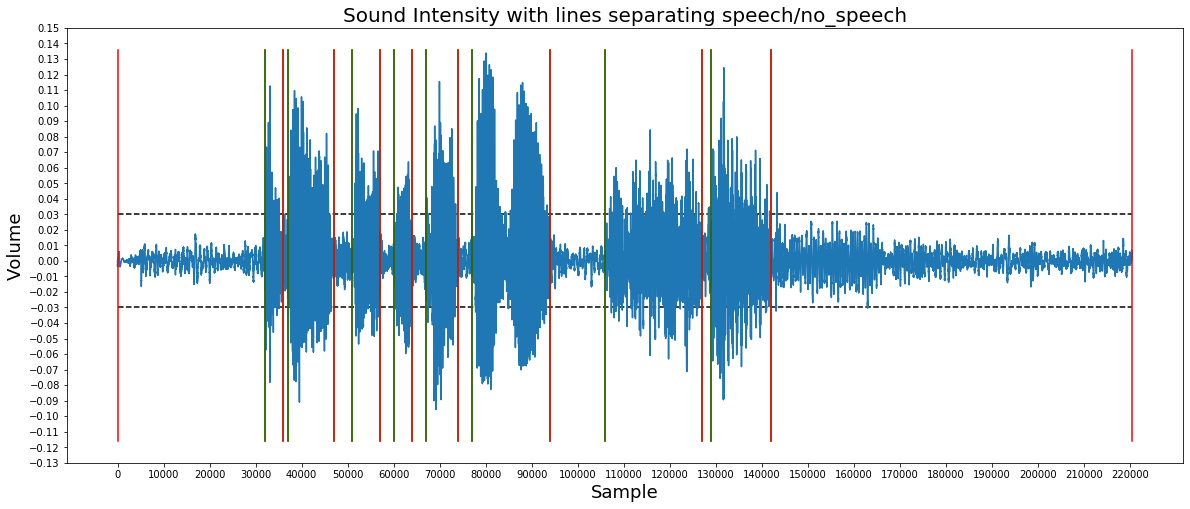

In [216]:
plt.figure(figsize=(20,8))
plt.plot(voice)

#horizontal lines
plt.hlines(y=cutoff_for_speaking, xmin=0, xmax=len(voice), colors='k', linestyles='dashed')
plt.hlines(y=-cutoff_for_speaking, xmin=0, xmax=len(voice), colors='k', linestyles='dashed')

#vertical lines
for dictionary in speaking_time:
    if dictionary['type']=='speech':
        clr = 'green'
    else:
        clr = 'red'
    plt.axvline(x=dictionary['start'], ymin=0.05, ymax=0.95, color=clr)#, ls='dashdot')
    plt.axvline(x=dictionary['end'], ymin=0.05, ymax=0.95, color=clr)#, ls='dashdot')

#our labels and ticks
plt.xticks(np.arange(0, freq*length, step=10000))
plt.yticks(np.arange(-0.13, 0.15, step=0.01))
plt.title('Sound Intensity with lines separating speech/no_speech', fontsize=20)
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Volume', fontsize=18)

### Now we'll color the signal depending on intensity

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


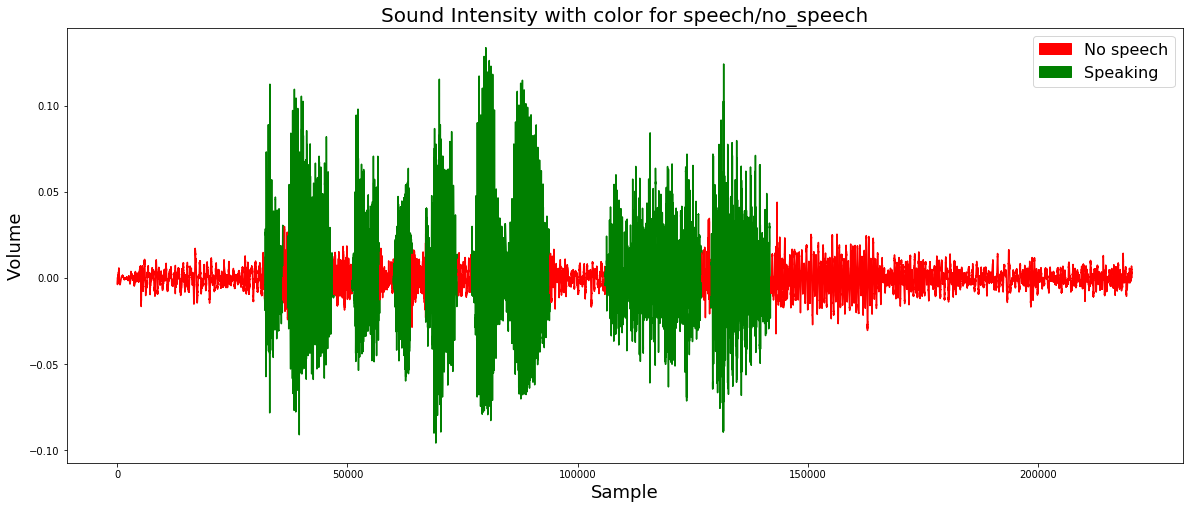

In [221]:
fig, ax = plt.subplots(figsize=(20,8))
for i in speaking_time:
    if i['type']=='speech':
        clr = 'green'
    else:
        clr = 'red'
#     x, y = zip(measurement['start'], measurement['end'])
    ax.plot(np.arange(i['start'], i['end'], 1), voice[i['start']:i['end']], color=clr)
red_patch = mpatches.Patch(color='red', label='No speech')
green_patch = mpatches.Patch(color='green', label='Speaking')
plt.legend(handles=[red_patch, green_patch], fontsize=16)
ax.set_title('Sound Intensity with color for speech/no_speech', fontsize=20)
ax.set_xlabel('Sample', fontsize=18)
ax.set_ylabel('Volume', fontsize=18)
plt.show()

### Wrap up
The sentence spoken was:

The brown fox jumps over the lazy dog.

Our graphical breakdwon looks about right since we spoke 8 words and we have 8 green sections of speech.

## Frequency Based Approach
In this approach, we will start by transforming to the frequency domain and applying a band pass filter for human speech (~200Hz-3400Hz).

### We'll start by reading our audio file

In [363]:
from scipy import signal

In [364]:
#recording of a sentence 
freq, voice = wavfile.read("gabi_sample.wav")
length = voice.shape[0]/freq
print("Sampling Frequency (Hz): ", freq)
print("Shape of our audio file: ", voice.shape)
print("Length of our audio file:", voice.shape[0]/freq, 'seconds')

Sampling Frequency (Hz):  44100
Shape of our audio file:  (220500,)
Length of our audio file: 5.0 seconds


In [365]:
ipd.Audio(voice, rate=freq)

### Now lets apply a bandpass filter for the array

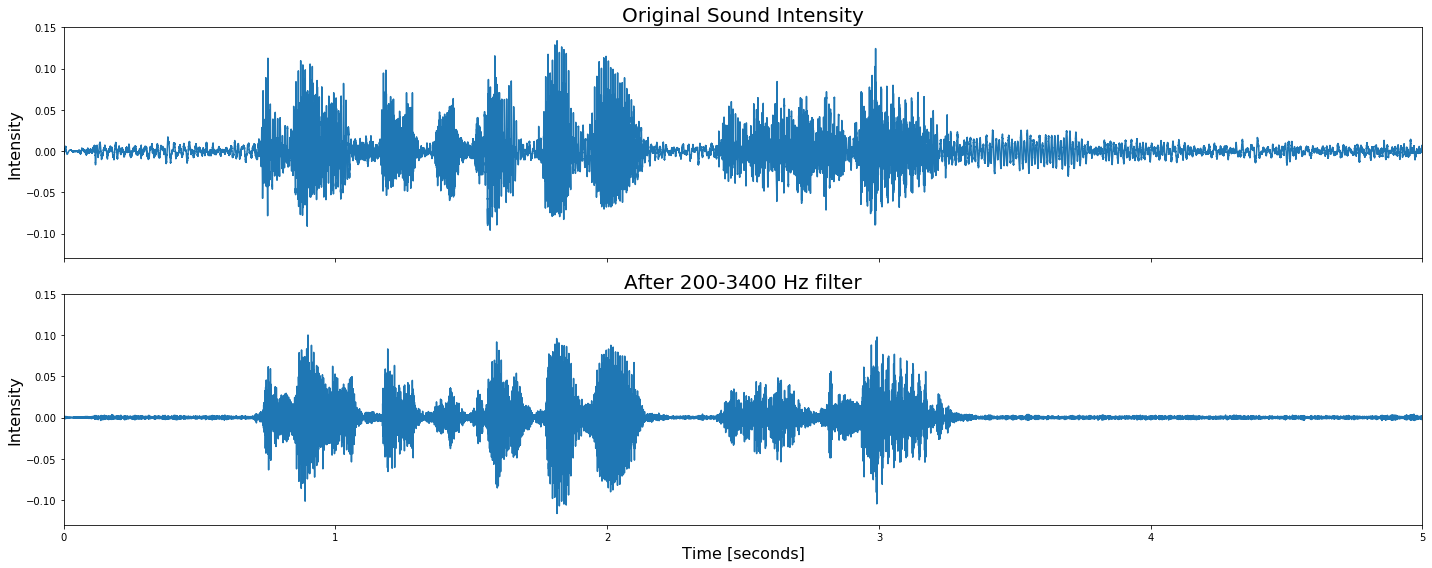

In [389]:
nsamples = len(voice)
t = np.linspace(0, 5, nsamples, endpoint=False)
low_pass = 200
high_pass = 3400

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,8))
ax1.plot(t, voice)
ax1.set_title('Original Sound Intensity', fontsize=20)
ax1.set_ylabel('Intensity', fontsize=16)
ax1.axis([0, 5, -.13, .15])

sos = signal.butter(50, [low_pass,high_pass], btype='bandpass', fs=freq, output='sos')
filtered = signal.sosfilt(sos, voice)
ax2.plot(t, filtered)
ax2.set_title('After 200-3400 Hz filter', fontsize=20)
ax2.axis([0, 5, -.13, .15])
ax2.set_xlabel('Time [seconds]', fontsize=16)
ax2.set_ylabel('Intensity', fontsize=16)
plt.tight_layout()
plt.show()

As you can see, the filtered signal looks less messy. Let's zoom in for a closer look

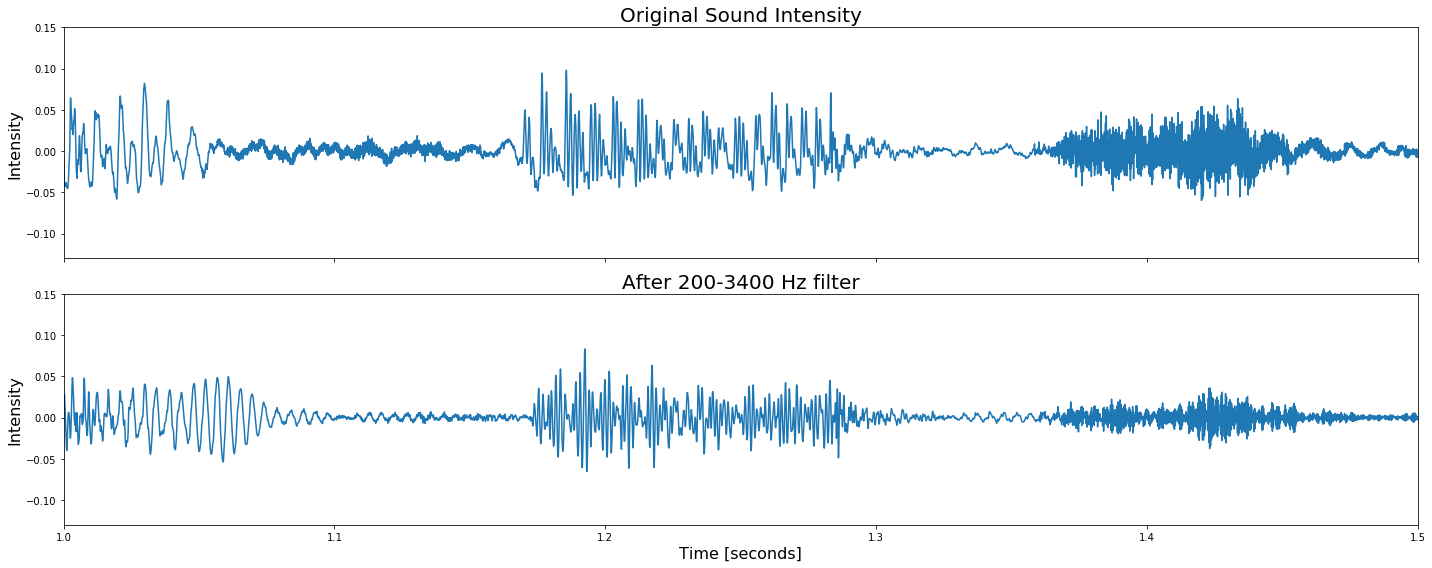

In [390]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,8))
ax1.plot(t, voice)
ax1.set_title('Original Sound Intensity', fontsize=20)
ax1.set_ylabel('Intensity', fontsize=16)
ax1.axis([0, 5, -.13, .15])

ax2.plot(t, filtered)
ax2.set_title('After 200-3400 Hz filter', fontsize=20)
ax2.axis([0, 5, -.13, .15])
ax2.set_xlabel('Time [seconds]', fontsize=16)
ax2.set_ylabel('Intensity', fontsize=16)
plt.xlim(1,1.5)
plt.tight_layout()
plt.show()

Now that we zoomed in, we can see how the filtered signal looks cleaner. We will no go back to our previous labeling steps using the filtered signal.

In [391]:
ipd.Audio(filtered, rate=freq)

### Take filtered signal and graph
Note there is much less noise so we can lower the cutoff for speaking bands from .03 to around .01

Text(0, 0.5, 'Volume')

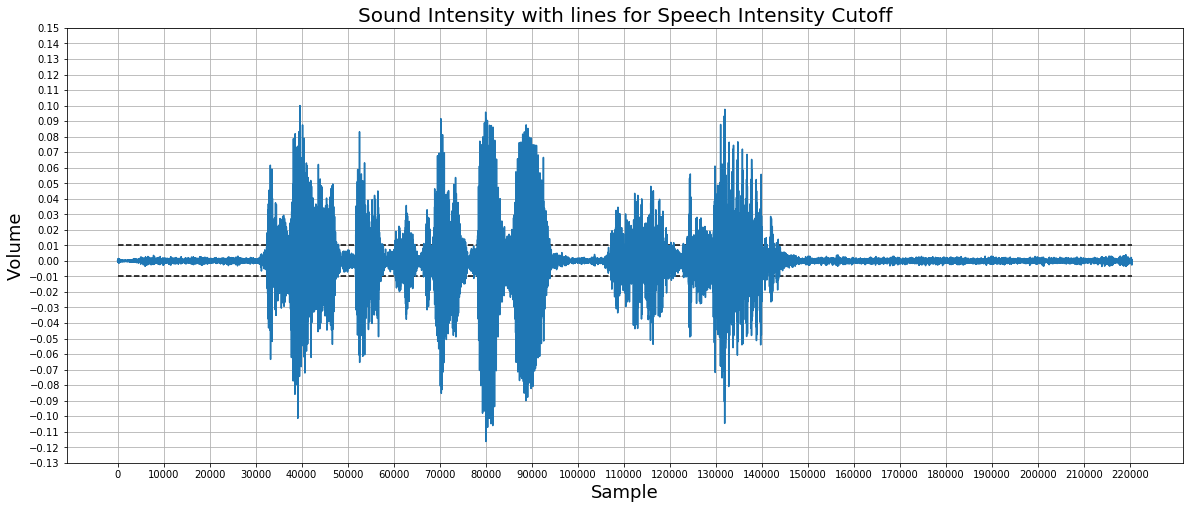

In [398]:
cutoff_for_speaking = 0.01   #we can adjust this later if we would like
plt.figure(figsize=(20,8))
plt.plot(filtered)

#horizontal lines
plt.hlines(y=cutoff_for_speaking, xmin=0, xmax=len(filtered), colors='k', linestyles='dashed')
plt.hlines(y=-cutoff_for_speaking, xmin=0, xmax=len(filtered), colors='k', linestyles='dashed')

#our labels and ticks
plt.xticks(np.arange(0, freq*length, step=10000))
plt.yticks(np.arange(-0.13, 0.15, step=0.01))
plt.grid(which='both', axis='both')
plt.title('Sound Intensity with lines for Speech Intensity Cutoff', fontsize=20)
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Volume', fontsize=18)

In [404]:
frame = 1000            #amount of points we look at when determining max amplitude 
amps= 10                #how many of the top values to average 
speaking_time = []      #list of dict that will store classification{start:int, stop:int,type:speech/silence}
current_start = 0       #the start of our current run
first_time_flag = True  #flag to run initial classification in for loop
speech_bool=True        #flag showing whether we are on a speech of silence run

#we look at frames of 1000 samples find the max value and determine speech or no speech
for idx, value in enumerate(filtered[::frame]):
    temp_array = filtered[idx*frame:(idx+1)*frame]
    #first we get or max amplitude for the frame
    avg_amp = np.average(np.sort(abs(temp_array))[-amps:])
    #below only executes on the first loop
    if first_time_flag:
        if avg_amp>cutoff_for_speaking:
            first_time_flag = False
            speech_bool = True
            current_start = ixd
            continue
        else:
            first_time_flag = False
            speech_bool = False
            current_start =idx
            continue
            
    if speech_bool: #on a speech run
        #then we will check if next value is also speech intenstiy
        if avg_amp<cutoff_for_speaking:
            speaking_time.append({'start':current_start, 'end':(idx)*frame, 'type': 'speech'})
            speech_bool = False
            current_start = idx*frame
            continue
            
        
    else: #check that next value is also not speech 
        if avg_amp>cutoff_for_speaking:
            speaking_time.append({'start':current_start, 'end':(idx)*frame, 'type': 'silence'})
            speech_bool= True
            current_start = idx*frame
            continue
            
#append final state to speaking_time
if speech_bool:
    speaking_time.append({'start':current_start, 'end':len(filtered), 'type': 'speech'})
else:   #ended with no speech
    speaking_time.append({'start':current_start, 'end':len(filtered), 'type': 'silence'})
  
    
            
print("Across our ", int(len(filtered)/frame), ' frames, we change our classification ', 
      len(speaking_time), ' times. ')

Across our  220  frames, we change our classification  15  times. 


### Let's graph these changes using vertical lines

### Let's graph these speaking/no speech with color

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


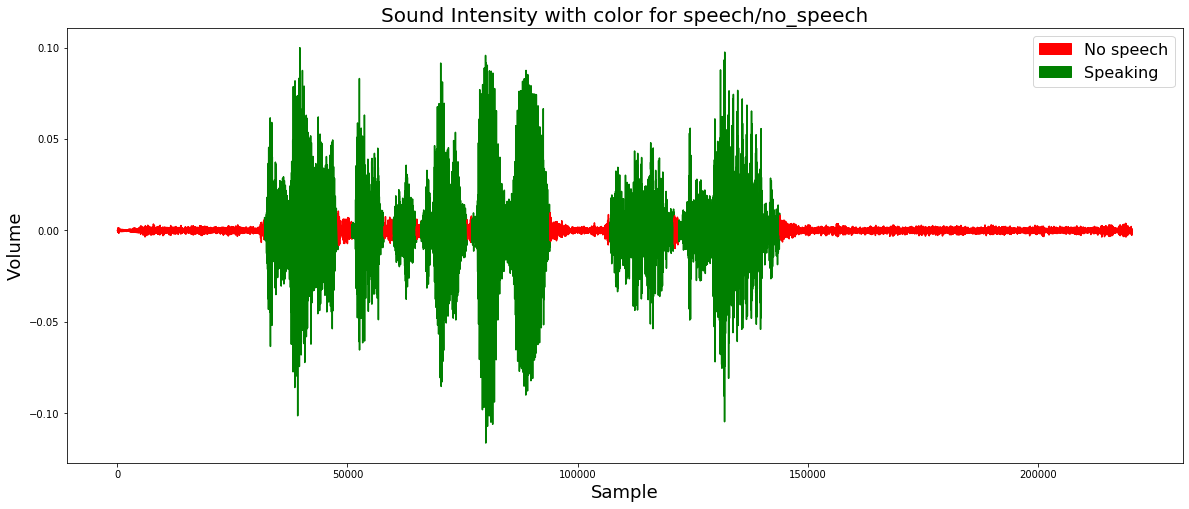

In [406]:
fig, ax = plt.subplots(figsize=(20,8))
for i in speaking_time:
    if i['type']=='speech':
        clr = 'green'
    else:
        clr = 'red'
#     x, y = zip(measurement['start'], measurement['end'])
    ax.plot(np.arange(i['start'], i['end'], 1), filtered[i['start']:i['end']], color=clr)
red_patch = mpatches.Patch(color='red', label='No speech')
green_patch = mpatches.Patch(color='green', label='Speaking')
plt.legend(handles=[red_patch, green_patch], fontsize=16)
ax.set_title('Sound Intensity with color for speech/no_speech', fontsize=20)
ax.set_xlabel('Sample', fontsize=18)
ax.set_ylabel('Volume', fontsize=18)
plt.show()